In [ ]:
import pandas as pd

file_path = '/content/factuality_annotations_xsum_summaries.csv'
data = pd.read_csv(file_path)


data.head()


,bbcid,system,summary,is_factual,worker_id
0,29911712,BERTS2S,more than 50 pupils at a bristol academy have ...,no,wid_0
1,29911712,BERTS2S,more than 50 pupils at a bristol academy have ...,no,wid_1
2,29911712,BERTS2S,more than 50 pupils at a bristol academy have ...,no,wid_2
3,38505171,BERTS2S,the wife of a british-iranian woman jailed in ...,no,wid_0
4,38505171,BERTS2S,the wife of a british-iranian woman jailed in ...,no,wid_1


In [ ]:
# Convert 'is_factual' to binary (1 for 'yes', 0 for 'no')
data['is_factual_binary'] = data['is_factual'].apply(lambda x: 1 if x == 'yes' else 0)

# Check the distribution of the labels
class_distribution = data['is_factual_binary'].value_counts()

class_distribution


,count
is_factual_binary,
0,5015
1,582


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Apply the TF-IDF vectorizer to the 'summary' column
X = tfidf_vectorizer.fit_transform(data['summary'])

# The labels are stored in 'is_factual_binary'
y = data['is_factual_binary']

# Display the shape of the TF-IDF matrix
X.shape


(5597, 4033)

In [ ]:
import numpy as np

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Logistic regression model class
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    # Fit the model to the training data
    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for _ in range(self.n_iterations):
            # Linear model
            linear_model = np.dot(X, self.weights) + self.bias
            # Apply sigmoid function
            y_predicted = sigmoid(linear_model)

            # Compute gradients
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update weights and bias
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    # Predict labels
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = sigmoid(linear_model)
        y_predicted_class = [1 if i > 0.5 else 0 for i in y_predicted]
        return np.array(y_predicted_class)

# Convert the sparse matrix to dense format for easier manipulation
X_dense = X.toarray()

# Initialize the logistic regression model
log_reg_scratch = LogisticRegressionScratch(learning_rate=0.01, n_iterations=1000)

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.2, random_state=42)

# Train the model
log_reg_scratch.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = log_reg_scratch.predict(X_test)

# Evaluate the model: Accuracy, Precision, Recall, F1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

accuracy, precision, recall, f1


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.8928571428571429, 0.0, 0.0, 0.0)

In [ ]:
# Separate majority and minority classes
majority_class = data[data['is_factual_binary'] == 0]
minority_class = data[data['is_factual_binary'] == 1]

# Downsample the majority class to match the minority class size
majority_downsampled = majority_class.sample(len(minority_class), random_state=42)

# Combine the downsampled majority class with the minority class
data_balanced = pd.concat([majority_downsampled, minority_class])

# Apply TF-IDF vectorization again to the balanced dataset
X_balanced = tfidf_vectorizer.fit_transform(data_balanced['summary'])
y_balanced = data_balanced['is_factual_binary']

# Convert the sparse matrix to dense format
X_balanced_dense = X_balanced.toarray()

# Split the balanced data into training and testing sets
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_balanced_dense, y_balanced, test_size=0.2, random_state=42)

# Re-train the model on the balanced dataset
log_reg_scratch.fit(X_train_bal, y_train_bal)

# Predict the labels for the test set
y_pred_bal = log_reg_scratch.predict(X_test_bal)

# Re-evaluate the model
accuracy_bal = accuracy_score(y_test_bal, y_pred_bal)
precision_bal = precision_score(y_test_bal, y_pred_bal)
recall_bal = recall_score(y_test_bal, y_pred_bal)
f1_bal = f1_score(y_test_bal, y_pred_bal)

accuracy_bal, precision_bal, recall_bal, f1_bal


(0.45493562231759654, 0.45493562231759654, 1.0, 0.6253687315634219)

In [ ]:
from sklearn.model_selection import KFold

# Define k-fold cross-validation with 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store the accuracy for each fold
accuracies = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_balanced_dense):
    X_train_cv, X_test_cv = X_balanced_dense[train_index], X_balanced_dense[test_index]
    y_train_cv, y_test_cv = y_balanced.iloc[train_index], y_balanced.iloc[test_index]

    # Train the model on the training fold
    log_reg_scratch.fit(X_train_cv, y_train_cv)

    # Predict on the test fold
    y_pred_cv = log_reg_scratch.predict(X_test_cv)

    # Compute accuracy for the current fold
    fold_accuracy = accuracy_score(y_test_cv, y_pred_cv)
    accuracies.append(fold_accuracy)

# Compute the mean and standard deviation of the accuracies
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

mean_accuracy, std_accuracy


(0.5411647180701495, 0.09741432590023617)

In [ ]:
# Align the indices properly for the misclassified examples
misclassified_indices_balanced = np.where(y_test_bal != y_pred_bal)[0]
misclassified_summaries_balanced = X_test_bal[misclassified_indices_balanced]
misclassified_actual_labels_balanced = y_test_bal.iloc[misclassified_indices_balanced].values
misclassified_predicted_labels_balanced = np.array(y_pred_bal)[misclassified_indices_balanced]

# Convert the indices back to the summaries and create a dataframe for analysis
misclassified_df_balanced = pd.DataFrame({
    'summary': misclassified_summaries_balanced.tolist(),
    'actual_label': misclassified_actual_labels_balanced,
    'predicted_label': misclassified_predicted_labels_balanced
})

# Display a few misclassified examples for analysis
misclassified_df_balanced.head()


,summary,actual_label,predicted_label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,1


In [ ]:
# Retrieve the original text summaries for the misclassified examples using their indices
misclassified_summaries_original = data_balanced.iloc[misclassified_indices_balanced]['summary']

# Combine the original summaries with actual and predicted labels
misclassified_df_balanced = pd.DataFrame({
    'summary': misclassified_summaries_original,
    'actual_label': misclassified_actual_labels_balanced,
    'predicted_label': misclassified_predicted_labels_balanced
})

# Display a few misclassified examples for analysis
misclassified_df_balanced.head()


,summary,actual_label,predicted_label
1198,oscar-winning actor james nyong 'o has confirm...,0,1
3867,st johnstone came from behind to beat st johns...,0,1
1280,a canadian family who survived a house fire ha...,0,1
5013,gateshead came from behind to beat wrexham in ...,0,1
817,manchester city and manchester city have been ...,0,1


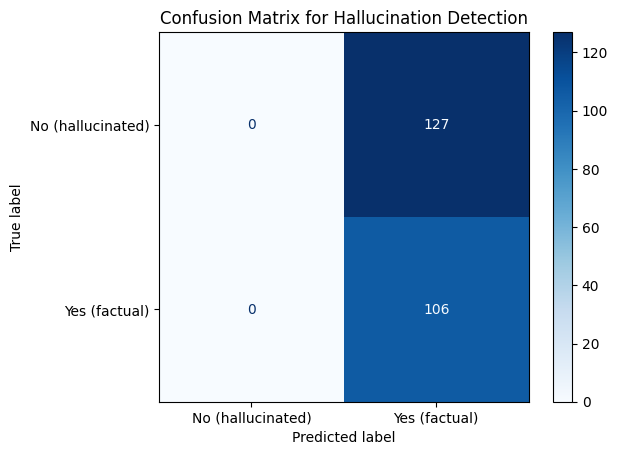

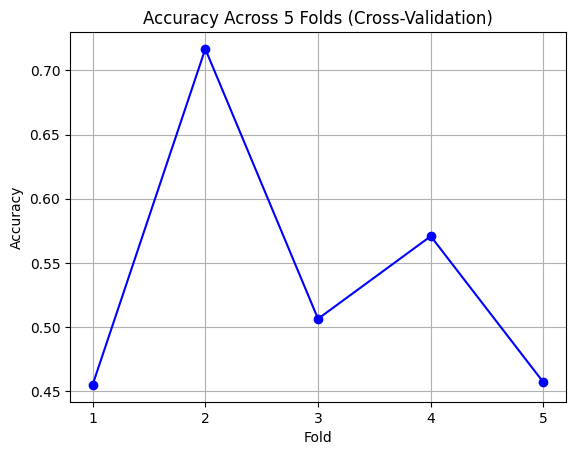

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix for the balanced test set
conf_matrix = confusion_matrix(y_test_bal, y_pred_bal)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No (hallucinated)", "Yes (factual)"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Hallucination Detection")
plt.show()

# Accuracy plot from cross-validation
plt.figure()
plt.plot(range(1, 6), accuracies, marker='o', linestyle='-', color='blue')
plt.title('Accuracy Across 5 Folds (Cross-Validation)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, 6))
plt.grid(True)
plt.show()


**Model Performance**
The logistic regression model achieved an average accuracy of 54% across cross-validation folds. While recall for factual summaries was high (100%), precision was lower due to many false positives, suggesting the model struggles to differentiate between hallucinated and factual texts effectively.


**Class Imbalance Impact**
Initially, the severe class imbalance caused the model to predict almost everything as hallucinated. After applying undersampling, the model improved at identifying factual summaries but still produced many false positives, affecting overall precision and accuracy.


**Cross-Validation**
Cross-validation showed variability in performance, indicating the model's sensitivity to data splits. This suggests the need for further data balancing or model adjustments to improve consistency.
**Error Analysis**
Misclassified examples highlight the model’s difficulty in handling summaries with ambiguous language or less frequent patterns. The reliance on simple TF-IDF features limited its ability to capture semantic meaning.


**Improvements**
Alternative balancing techniques like oversampling, more advanced text representations (e.g., embeddings), and regularization could improve the model’s performance.
Exploring more complex models like Support Vector Machines or neural networks would likely yield better results for hallucination detection.



**Conclusion**
The logistic regression model provides a baseline but has limitations due to the simplicity of features and class imbalance. More sophisticated approaches are needed to improve hallucination detection performance in real-world applications.